**TP : Modélisation d'un système réel de lentilles d'un objectif d'appareil photo**

**But**: Dans le cadre d'un algorithme de ray tracing, nous devons, à partir de la documentation d'un vrai appareil photo, tracer un rayon partant du capteur de l'appareil photo, passant à travers toutes les lentilles et sortant de l'objectif.

Données : Vous pouvez retrouver toutes les caractéristiques et leur explication avec ce lien : https://pbr-book.org/3ed-2018/Camera_Models/Realistic_Cameras
On en peut mettre les valeurs dans une liste :
[[35.98738, 1.21638, 1.54, 23.716], [11.69718, 9.9957, 1.0, 17.996], [13.08714, 5.12622, 1.772, 12.364], [-22.63294, 1.76924, 1.617, 9.812], [71.05802, 0.8184, 1.0, 9.152], [0, 2.27766, 1, 8.756], [-9.58584, 2.43254, 1.617, 8.184], [-11.28864, 0.11506, 1.0, 9.152], [-166.7765, 3.09606, 1.713, 10.648], [-7.5911, 1.32682, 1.805, 11.44], [-16.7662, 3.98068, 1.0, 12.276], [-7.70286, 1.21638, 1.617, 13.42], [-11.97328, 0, 1.0, 17.996]]

Cette liste donnent les courbures des lentilles de gauche à droite (de là où rentre la lumière vers le capteur). Toutefois, nous faisont le chemin inverse de la lumière, le plus simple est donc de retourner cette liste.

In [1]:
data = [[35.98738, 1.21638, 1.54, 23.716],  #liste des courbures de PBRT
    [11.69718, 9.9957, 1.0, 17.996],
    [13.08714, 5.12622, 1.772, 12.364],
    [-22.63294, 1.76924, 1.617, 9.812],
    [71.05802, 0.8184, 1.0, 9.152],
    [0, 2.27766, 1, 8.756],
    [-9.58584, 2.43254, 1.617, 8.184],
    [-11.28864, 0.11506, 1.0, 9.152],
    [-166.7765, 3.09606, 1.713, 10.648],
    [-7.5911, 1.32682, 1.805, 11.44],
    [-16.7662, 3.98068, 1.0, 12.276],
    [-7.70286, 1.21638, 1.617, 13.42],
    [-11.97328, 0, 1.0, 17.996]]

datas = [[313.397, 13.228, 1.717, 54.2],  #  autre liste d'un vrai objectif (celui de PBRT ne fonctionne pas)
    [-946.808, 0.529, 1.0, 54.2],
    [356.969, 6.614, 1.613, 50.3],
    [62.886, 150.058, 1.0, 42.3],
    [80.585, 14.815, 1.613, 34.4],
    [-255.538, 13.493, 1.0, 34.4],
    [-107.490, 6.085, 1.689, 26.5],
    [82.225, 16.879, 1.0, 26.5],
    [-709.945, 9.260, 1.613, 34.4],
    [-124.555, 0.529, 1.0, 34.4],
    [-181.964, 12.699, 1.613, 34.4],
    [-137.677, 10, 1.0, 34.4]]


Liste_lens = data[::-1]   #liste inversée


La premère étape est de pouvoir tracer les courbures pour symboliser les lentilles

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def dessiner_courbure(centre, rayon, taille_courbure):
    x_c, y_c = centre

    if rayon == 0:  # Cas d'une ligne droite verticale (rayon infini)
        x = x_c # Position X de la droite
        y = np.linspace(-taille_courbure / 2, taille_courbure / 2, 500)  # Position Y de la droite
        x = [x] * len(y)  # Répéter la position x pour chaque point y

    else:  # Cas d'un arc de cercle
        angles = np.linspace(-np.arcsin(taille_courbure / (2 * rayon)), np.arcsin(taille_courbure / (2 * rayon)), 500)  # Calcul des angles pour dessiner l'arc de cercle
        x = x_c - rayon * np.cos(angles)  # Coordonnées x de l'arc
        y = y_c  - rayon * np.sin(angles)  # Coordonnées y de l'arc# Calcul des angles pour dessiner l'arc de cercle
    
    return x, y

On peut afficher le système optique :

In [16]:
def systeme_optiques(Liste_lens):

    plt.figure()  # Création de la figure pour l'affichage
    rayon = 0  #Initialisation du rayon
    centre = [0, 0]  # Point de départ pour la première lentille
    
    # Boucle sur chaque lentille dans la liste
    for Len in Liste_lens:
        rayon = Len[0]
        centre = (centre[0] - Len[1] + rayon , centre [1])  # Mise à jour du centre en fonction de l'épaisseur
        x, y = dessiner_courbure(centre, rayon , Len[3])

        #  différençons le diaphragme du reste
        if rayon == 0 : 
            plt.plot(x, y, color = 'black' )  # Tracé du diaphragme
        elif rayon != 0 :
            plt.plot(x, y, color = 'black' )  # Tracé des courbures
        centre = (centre[0] - rayon , centre [1])  #on se replace à l'intersection de la lentille avec l'axe des abscisses
        
    # Configuration de l'affichage
    #plt.axis('equal')  # Pour que les axes soient à la même échelle
    plt.xlim(-40, 10)  # Limites de l'axe X
    plt.ylim(-15, 15)  # Limites de l'axe Y
    plt.title("Système Optique (Courbures)")  # Titre du graphique
    plt.grid(True)  # Affichage de la grille
    plt.show()  # Affichage du graphique

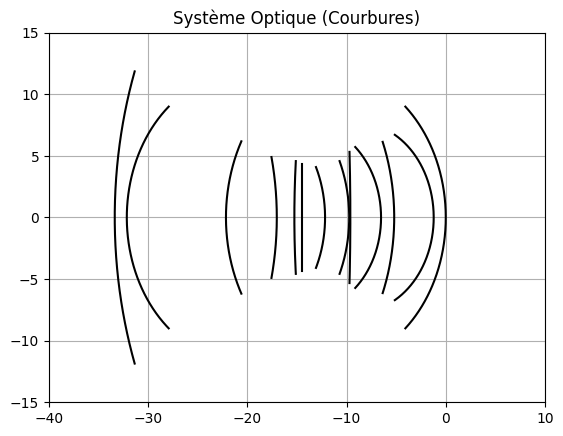

In [17]:
systeme_optiques(Liste_lens)

Maintenant, nous pouvons commencer à tracer les rayons. Pour cela, il faut faire une boucle for sur les lentilles dans laquelle on vérifie que la rayon "hit" bien la prochaine courbure :
- si oui, on trouve le point d'intersection et calcule la nouvelle direction
- si non, le rayon est mort

On initialisera le programme en donnant une origine (un point du capteur) et une direction initiale.

Commençons par la fonction "hit" prenant en argument l'origine et la direction du rayon incident et le centre, le rayon et l'"aperture" de la courbure correspondante. Cette fonction doit renvoyer :
 - le booléen True et le point d'intersection si le rayon "hit"
ou bien
 - le booléen False sinon

In [18]:
def hit(origine, direction, centre, radius, aperture): 

    # conversion des listes en arrays pour pouvoir faire des opérations
    origine = np.array(origine)  
    direction = np.array(direction)
    centre = np.array(centre)
    
    p_hit = []  #initialisation du p_hit

    #  Constante du polynome du second degrée perméttant de calculer le point d'intersection du rayon avec la courbure 
    #  Pour cela, revenir à l'équation d'un cercle et du rayon incident
    a = 1  
    b = 2* np.dot(direction, origine) - 2*np.dot(centre,direction) # Le produit scalaire entre direction et oc
    c = np.dot(origine, origine) + np.dot(centre,centre) - 2*np.dot(centre, origine) - radius * radius  # La norme au carré de oc - rayon^2
    
    discriminant = b**2 - 4* a*c  # calcule du discriminant
    
    if discriminant<=0 :   # si le discriminant est négatif ou nul, le rayon ne hit pas la courbure
        return (False, "none") 
        
    else:  #  disjonction de cas suivant le signe du rayon (la racine qui nous intéresse change suivant ce signe)
        if radius > 0 :
            root = (-b + np.sqrt(discriminant)) / (2*a) # on veut la racine la plus grande
            if root > 0 :  #  la racine doit être positive, sinon cela veut dire qu'on remonte dans le temps...
                p_hit = origine + direction * root # calcule du point d'intersection 
                if abs(p_hit[1]) <= aperture/2 :  #  verification que le point est bien sur la partie de la courbure délimitée par l'aperture
                    return (True, p_hit.tolist())
        if radius < 0 :
            root = (-b - np.sqrt(discriminant)) / (2*a)  # on veut la racine la plus petite
            if root > 0 :  #  la racine doit être positive, sinon cela veut dire qu'on remonte dans le temps...
                p_hit = origine + direction * root  # calcule du point d'intersection 
                if abs(p_hit[1]) <= aperture/2 :  #  verification que le point est bien sur la partie de la courbure délimitée par l'aperture
                    return (True, p_hit.tolist())
    return (False, "none")

Maintenant qu'on connait le point d'intersection, on peut calculer la nouvelle direction du rayon émergeant grâce à Snell-Descartes. Pour cela écrivons une fonction normaliser pour pouvoir travailler avec des vecteurs normalisés facilitant de calculer l'angle d'incidence.

In [19]:
def normaliser(vecteur):
    norme = np.linalg.norm(vecteur) 
    if norme == 0: 
        return vecteur 
    return vecteur / norme

La fonction réfraction prend en argument l'origine et la direction du rayon incident, le centre et le rayon de la courbure correspondante et l'indice des deux milieux. Elle doit renvoyer la nouvelle direction du rayon émergeant et son origine (déja donné par hit).

In [20]:
def refraction (direction, p_hit, ancien_indice, nouvel_indice, centre, rayon):
    
    normale = normaliser([p_hit[0]-centre[0], p_hit[1]-centre[1]])  #  normalisation de la normale au dioptre

    #  disjonction de cas suivant le signe du rayon (le calcul de l'angle d'incidence change suivant ce signe)
    if rayon < 0 :
        #  disjonction de cas suivant le type de réflexion / réfraction
        if abs( np.sin(np.pi - np.arccos (np.dot(direction, normale))) * ancien_indice / nouvel_indice) <= 1 :  #  réfraction et réflexion
            theta = np.arcsin (np.sin(np.pi - np.arccos (np.dot(direction, normale))) * ancien_indice / nouvel_indice)  
        else : 
            theta = np.pi/2  # réflexion totale (on la néglige, théta = pi/2)
            
        direction = np.dot(-normale,[[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])  # formule de rotation d'angle théta
    else :
         #  disjonction de cas suivant le type de réflexion / réfraction
         if abs( np.sin(np.arccos (np.dot(direction, normale))) * ancien_indice / nouvel_indice) <= 1 :  #  réfraction et réflexion
            theta = - np.arcsin (np.sin(np.arccos (np.dot(direction, normale))) * ancien_indice / nouvel_indice)
         else : 
            theta = - np.pi/2  # réflexion totale (on la néglige, théta = pi/2)
             
         direction = np.dot(normale,[[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])  # formule de rotation d'angle théta
        
    return p_hit, normaliser(direction)

Pour finir, il suiffit d'écrire la fonction de traçage de rayons : 

In [21]:
def tracer_droite(point1, point2):
    x1, y1 = point1[0],point1[1]
    x2, y2 = point2[0],point2[1]

    plt.plot([x1, x2], [y1, y2], color='red')

On peut enfin écrire la main fonction pour tracer l'ensemble du sytème avec le rayon :

In [23]:
def systeme_optique(Liste_lens):

    plt.figure()  # Création de la figure pour l'affichage
    rayon = 0  #Initialisation du rayon
    centre = [0, 0]  # Point de départ pour la première lentille
    origine = [10,0] # pixel d'origine
    direction = normaliser([-10,2]) # direction d'origine
    ancien_indice = 1 #initialisation
    nouvel_indice = 1 #initialisation
    next_len = 1 #indice de lentille pour pouvoir accéder à l'indice du milieu à gauche de la surface (car le rayon fait le parcours inverse de la lumière normal)
    p_hit = [0, 0]
    # Boucle sur chaque lentille dans la liste
    for Len in Liste_lens:
        rayon = Len[0]
        nouvel_indice = Liste_lens[next_len][2] if next_len < len(Liste_lens) else 1   #  le 1 est important pour la dernière lentille
        centre = (centre[0] - Len[1] + rayon , 0)  # Mise à jour du centre en fonction de l'épaisseur
        x, y = dessiner_courbure(centre, rayon , Len[3])
        
        #  différençons le diaphragme du reste
        if rayon == 0 : 
            plt.plot(x, y, color = 'black' )  # Tracé du diaphragme
        elif rayon != 0 :
            plt.plot(x, y, color = 'black' )  # Tracé des courbures
            
        #  calcul de l'intersection du rayon pour les courbures
        if rayon != 0 :
            result = hit (origine, direction, centre, rayon, Len[3])
            condition= result[0]

            #  le rayon touche ou non
            if condition :
                p_hit = result[1]  #  point d'intersection
                tracer_droite (origine, p_hit) #  traçage du rayon
                origine, direction = refraction (direction, p_hit, ancien_indice, nouvel_indice, centre, rayon)
            else : 
                tracer_droite(p_hit, [p_hit[0]+10*direction[0], p_hit[1]+10*direction[1]]) #  on prolonge le rayon
                return f"Le rayon ne touche pas la courbure n° {next_len} "
            
            next_len += 1  #  next_len est dans le if pour ne pas compter le diaphragme
      
        #  mise à jour des variables
        ancien_indice = nouvel_indice
        centre = (centre[0] - rayon , centre [1])  #on se replace à l'intersection de la lentille avec l'axe des abscisses
    
    tracer_droite(p_hit, [p_hit[0]+300*direction[0], p_hit[1]+300*direction[1]]) # on prolonge le denrier rayon

    # Configuration de l'affichage
    #plt.axis('equal')  # Pour que les axes soient à la même échelle
    plt.xlim(-40, 10)  # Limites de l'axe X
    plt.ylim(-15, 10)  # Limites de l'axe Y
    plt.title("Système Optique (Courbures)")  # Titre du graphique
    #plt.grid(True)  # Affichage de la grille
    plt.show()  # Affichage du graphique

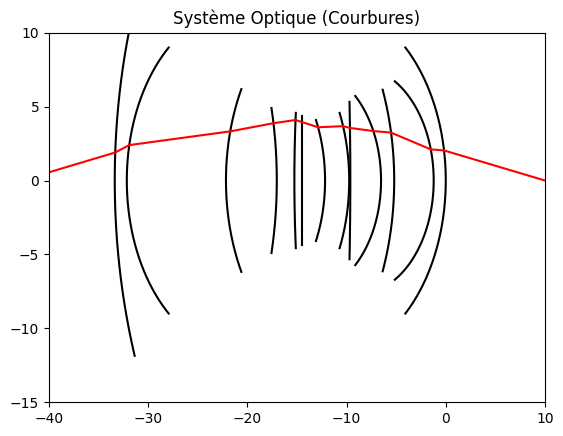

In [24]:
systeme_optique(Liste_lens)